In [5]:
import xarray as xr
import rioxarray as rx
import dask
import datacube

import matplotlib.pyplot as plt
from dask.distributed import Client

%matplotlib inline

In [6]:
# 384 hour forecasts for each time (16 * 24)
url = "https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p25.pl?file=gfs.t12z.pgrb2.0p25.f018&lev_975_mb=on&var_UGRD=on&subregion=&leftlon=100&rightlon=160&toplat=0&bottomlat=-50&dir=%2Fgfs.20220301%2F12%2Fatmos"

In [10]:
a = "The {t} number {n}"
a.format(t = "test", n = "")

'The test number '

In [ ]:
import wget

print('Beginning file download with wget module')

out = '/home/rvalavi/Downloads/file1'

wget.download(url, out)

In [30]:
base = "https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p25.pl?file=gfs.t{time}z.pgrb2.0p25.f{nforecast}&lev_{level}_mb=on&var_{component}=on&subregion=&leftlon={xmin}&rightlon={xmax}&toplat={ymin}&bottomlat={ymax}&dir=%2Fgfs.{date}%2F{time}%2Fatmos"
url = base.format(date='20220301', time='00', nforecast='010', component='VGRD', level=975, xmin=100, xmax=160, ymin=1, ymax=-50)
url

'https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p25.pl?file=gfs.t00z.pgrb2.0p25.f010&lev_975_mb=on&var_VGRD=on&subregion=&leftlon=100&rightlon=160&toplat=1&bottomlat=-50&dir=%2Fgfs.20220301%2F00%2Fatmos'

In [31]:
name = "gfs_{comp}_{date}_t{time}z_f{nf}".format(date='20220301', time='00', nf='010', comp='VGRD'.lower())
outdir = '/home/rvalavi/Downloads'
out = os.path.join(outdir, name)

out

'/home/rvalavi/Downloads/gfs_vgrd_20220301_t00z_f010'

In [32]:
wget.download(url, out)

-1 / unknown

'/home/rvalavi/Downloads/gfs_vgrd_20220301_t00z_f010'

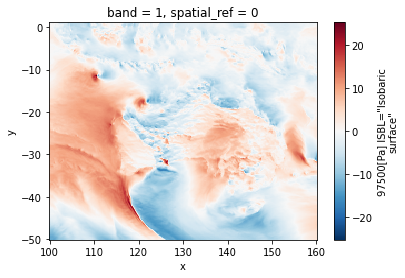

In [33]:
r = rx.open_rasterio(out)
r.plot()

In [41]:
a = 1
str(a).zfill(3)

'001'

In [ ]:
def download_wind(date, time='00', nforecast=10, component='VGRD', level=975, outdir, xmin=100, xmax=160, ymin=1, ymax=-50):
    import os, wget
    nforecast = str(nforecast).zfill(3) # convert to string and pad 0s if necessary
    base = "https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p25.pl?file=gfs.t{time}z.pgrb2.0p25.f{nf}&lev_{level}_mb=on&var_{comp}=on&subregion=&leftlon={xmin}&rightlon={xmax}&toplat={ymin}&bottomlat={ymax}&dir=%2Fgfs.{date}%2F{time}%2Fatmos"
    url = base.format(date=date, time=time, nf=nforecast, comp=component, level=level, xn=xmin, xx=xmax, yn=ymin, yx=ymax)
    
    for in in range(len(date)):
        for i in range(len(nforecast)):
            name = "gfs_{comp}_{date}_t{time}z_f{nf}".format(comp=component.lower(), date=date, time=time, nf=nforecast)
            out = os.path.join(outdir, name)
            